## Generalized $\mathcal{C}^1$-smooth Average-based Robustness for Optimization with Signal Temporal Logic Specifications (D-GSAR)

---

### UNTIL

\begin{align*}
    \Gamma^{ \varphi_1 \boldsymbol{U}_{[a : b]} \varphi_2}  (x,k) := {}^{\vee} h_{p, w}^{\epsilon}(( &{}^{\wedge} h_{p, w}^{\epsilon}(( \Gamma^{ \boldsymbol{G}_{[a : a]} \; \varphi_1}(x, k), \Gamma^{ \varphi_2 }(x, k+a) )), \\
    &{}^{\wedge} h_{p, w}^{\epsilon}(( \Gamma^{ \boldsymbol{G}_{[a : a+1]} \; \varphi_1}(x, k), \Gamma^{ \varphi_2 }(x, k+a+1) )), \\
    &\hspace{0.4cm}\vdots \\
    &{}^{\wedge} h_{p, w}^{\epsilon}(( \Gamma^{ \boldsymbol{G}_{[a : b]} \; \varphi_1}(x, k), \Gamma^{ \varphi_2 }(x, k+b) ))))
\end{align*}

Suppose that $\Gamma^{\varphi_1}(x,k) = f(x_k)$ and $\Gamma^{\varphi_2}(x,k) = g(x_k)$. Let
\begin{align*}
    z   :=& \Gamma^{ \varphi_1 \boldsymbol{U}_{[1 : N]} \varphi_2} (x,0) \\
         =& {}^{\vee} h_{p, w}^{\epsilon}(( s_1, s_2, \dots, s_N))\\
    s_i :=& {}^{\wedge} h_{p, w}^{\epsilon}(( y_i, g(x_i) )) \text{ for all $i \in [1:N]$ } \\
    y_i :=& {}^{\wedge} h_{p, w}^{\epsilon}(( f(x_1), f(x_2), \dots, f(x_i) )) \text{ for all $i \in [1:N]$ } \\
\end{align*}

Then
\begin{align*}
    \frac{\partial z}{\partial f(x_i)} &= \sum_{j=1}^{i} \frac{\partial z}{\partial s_j}  \frac{\partial s_j}{\partial y_j} \frac{\partial y_j}{\partial f(x_j)}\\
    \frac{\partial z}{\partial g(x_i)} &= \frac{\partial z}{\partial s_i}  \frac{\partial s_i}{\partial g(x_i)}
\end{align*}

# Libraries

In [29]:
import numpy as np
import cvxpy as cp
import sympy as sp

import typing as T
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import os
import glob
from PIL import Image
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120 
mpl.rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']}) ## for Palatino and other serif fonts use: #rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
from cycler import cycler
# mpl.rcParams['axes.prop_cycle'] = cycler(color='rkgbcmy')
mpl.rcParams['axes.prop_cycle'] = cycler(color=['tab:red', 'k', 'tab:green', 'tab:blue', 'tab:grey'])
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams.update({'font.size': 12})
mpl.rcParams.update({'legend.fontsize': 11})
mpl.rcParams.update({'axes.xmargin': 0})
mpl.rcParams.update({'lines.solid_capstyle': 'round'})
mpl.rcParams.update({'lines.solid_joinstyle': 'round'})
mpl.rcParams.update({'lines.dash_capstyle': 'round'})
mpl.rcParams.update({'lines.dash_joinstyle': 'round'})
mpl.rcParams.update({'text.latex.preamble': r"\usepackage{bm}"})

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

save_fig = False
fig_format = ['pdf', 'png'][0]

In [30]:
def gsar_sympy(eps : float,
               p : int,
               weights : np.ndarray,
               N : int) -> T.Tuple[T.Any]:

    """
    :return: Functions to calculate f and A given state x
    """
        
    f = sp.zeros(2, 1)
    x = sp.Matrix(sp.symbols(['x'+str(i) for i in range(N)], real=True))
    
    fp_2 = sp.Matrix([sp.Max(0, i)**2 for i in x])
    fn_2 = sp.Matrix([sp.Min(0, i)**2 for i in x])

    fp_2p = sp.Matrix([sp.Max(0, i)**(2*p) for i in x])
    fn_2p = sp.Matrix([sp.Min(0, i)**(2*p) for i in x])
    
    M0_fp = 1
    M0_fn = 1
    
    Mp_fp = 0
    Mp_fn = 0
    
    sum_w = np.sum(weights)

    for i in range(N):
        w_i = int(weights[i])
        
        M0_fp = M0_fp * (fp_2[i]**w_i)
        M0_fn = M0_fn * (fn_2[i]**w_i)
        
        Mp_fp = Mp_fp + w_i*fp_2p[i]/sum_w
        Mp_fn = Mp_fn + w_i*fn_2p[i]/sum_w
        
    M0_fp = (eps**(sum_w) + M0_fp)**(1/sum_w)
    M0_fn = (eps**(sum_w) + M0_fn)**(1/sum_w)
    
    Mp_fp = (eps**(p) + Mp_fp)**(1/p)
    Mp_fn = (eps**(p) + Mp_fn)**(1/p)
    
    f[0, 0] = M0_fp**(1/2) - Mp_fn**(1/2) # {}^{\wedge} h_{p, w}^{\epsilon}
    f[1, 0] = Mp_fp**(1/2) - M0_fn**(1/2) # {}^{\vee}   h_{p, w}^{\epsilon}
    
    A = f.jacobian(x)

    f_func = sp.lambdify((x,), f, 'numpy')
    A_func = sp.lambdify((x,), A, 'numpy')

    return f_func, A_func

In [31]:
def ssr_sympy(k : int, 
              N : int) -> T.Tuple[T.Any]:
    """
    :return: Functions to calculate A, B and f given state x and input u
    """
        
    f = sp.zeros(2, 1)
    x = sp.Matrix(sp.symbols(['x'+str(i) for i in range(N)], real=True))

    def max_aprx(x, k, N):
        sum_1 = 0.
        sum_2 = 0.
        for i in range(N):
            sum_1 = sum_1 + x[i] * sp.exp(k * x[i])
            sum_2 = sum_2 + sp.exp(k * x[i])
        return sum_1 / sum_2

    def min_aprx(x, k, N):
        sum_1 = 0.
        for i in range(N):
            sum_1 = sum_1 + sp.exp(k * -x[i])
        return -1/k * sp.log(sum_1)
    
    f[0, 0] = min_aprx(x, k, N)
    f[1, 0] = max_aprx(x, k, N)
    
    A = f.jacobian(x)

    f_func = sp.lambdify((x,), f, 'numpy')
    A_func = sp.lambdify((x,), A, 'numpy')

    return f_func, A_func

In [32]:
def gsar_and(eps : float,
             p : int,
             weights : np.ndarray,
             *args : T.Tuple[T.Any]) -> T.Tuple[T.Any]:
    '''
    Input: The values of the functions and their gradients to be connected with And -> ( f, gf, g, gg, h, gh, ... )
    Output: gsar_and function's value its gradient -> ( And(f,g,h, ...), And(gf, gg, gh) )
    '''
    
    N = len(args[0])
    fcn_vals = args[0]
    
    pos_idx = list(idx for idx, ele in enumerate(fcn_vals) if ele > 0.)
    neg_idx = list(idx for idx, ele in enumerate(fcn_vals) if ele <=  0.)
    
    pos_vals = fcn_vals[pos_idx]
    neg_vals = fcn_vals[neg_idx]
    
    pos_w = weights[pos_idx]
    neg_w = weights[neg_idx]
    
    sum_w = np.array(weights).sum()

    if neg_idx:
        # If there exits a negative element
        
        # Fcn Val
        sums = 0.
        for idx, neg_val in enumerate(neg_vals):
            sums = sums + neg_w[idx] * (neg_val**(2*p))
        
        Mp = (eps**(p) + (sums / sum_w))**(1/p)
        h_and = eps**(1/2) - Mp**(1/2) # It is coming from the other one
        
        # Grad
        cp = 1/2 * Mp**(-1/2)
        cpm = 2*p / (p * sum_w * Mp**(p-1))
        
        c_i_w_i = np.zeros(N)
        c_i_w_i[neg_idx] = [ cp*cpm*(neg_w[idx] * (np.abs(neg_val))**(2*p-1)) for idx, neg_val in enumerate(neg_vals) ]
            
    else:
        # IF all are positive
        
        # Fcn Val
        mult = 1.
        for idx, pos_val in enumerate(pos_vals):
            mult = mult * ((pos_val)**(2*pos_w[idx]))

        M0 = (eps**(sum_w) + mult)**(1/sum_w)
        h_and = M0**(1/2) - eps**(1/2) # It is coming from the other one
        
        # Grad
        c0 = 1/2 * M0**(-1/2)
        c0m = ( 2 * mult ) / ( sum_w * M0**(sum_w-1) )
                
        c_i_w_i = np.zeros(N)
        c_i_w_i[pos_idx] = [ c0*c0m*(pos_w[idx] / pos_val) for idx, pos_val in enumerate(pos_vals) ]
    
    return h_and, c_i_w_i

def gsar_or(eps, p, weights, *args):
    '''
    Input: The values of the functions and their gradients to be connected with Or
    Output: gsar_or function's value its gradient
    '''
    
    args = -args[0]
    h_mor, d_i_w_i = gsar_and(eps, p, weights, args)
    return -h_mor, d_i_w_i

In [33]:
def verify_gsar_fcn(ITE : int):

    err_arr = np.zeros(8)
    for _ in range(ITE):
    
        N = np.random.randint(10, 20)
        p = np.random.randint(1, 8)
        eps = 0.1 * np.random.rand()
        weights = np.random.randint(1, 10, size=N)

        f_func, A_func = gsar_sympy(eps, p, weights, N)

        y = np.random.rand(N)
        h_and, h_and_grad = gsar_and(eps, p, weights, y)
        h_or, h_or_grad = gsar_or(eps, p, weights, y)

        err_arr[0] = (f_func(y)[0,:] - h_and).sum()
        err_arr[1] = (A_func(y)[0,:] - h_and_grad).sum()
        err_arr[2] = (f_func(y)[1,:] - h_or).sum()
        err_arr[3] = (A_func(y)[1,:] - h_or_grad).sum()

        x = y - 0.5
        h_and, h_and_grad = gsar_and(eps, p, weights, x)
        h_or, h_or_grad = gsar_or(eps, p, weights, x)

        err_arr[4] = (f_func(x)[0,:] - h_and).sum()
        err_arr[5] = (A_func(x)[0,:] - h_and_grad).sum()
        err_arr[6] = (f_func(x)[1,:] - h_or).sum()
        err_arr[7] = (A_func(x)[1,:] - h_or_grad).sum()

        if err_arr.sum() > 1e-8:
            print(err_arr.sum())
            print('Implementation of D-GSAR is wrong!')

In [34]:
verify_gsar_fcn(ITE=5)

In [35]:
def UNTIL(eps : float, 
          p : int, 
          w_f : np.ndarray, 
          w_g : np.ndarray,
          w_fg : np.ndarray, 
          f : np.ndarray,
          g : np.ndarray) -> T.Tuple[T.Any]:
    
    s = []
    ds_dg = []
    ds_df = []
    
    N = f.shape[0]
    
    for i in range(N):
        y_i, dyi_dfi = gsar_and(eps, p, w_f[0:i+1], f[0:i+1])
        s_i, dsi_dyi__dsi_dgi = gsar_and(eps, p, w_fg[0:2], np.array([y_i, g[i]]))

        dsi_dyi = dsi_dyi__dsi_dgi[0]
        dsi_dgi = dsi_dyi__dsi_dgi[1]
        dsi_dfi = dsi_dyi * dyi_dfi

        s.append(s_i)
        ds_dg.append(dsi_dgi)
        ds_df.append(dsi_dfi)
    
    z, dz_ds = gsar_or(eps, p, w_g, np.array(s))
    
    dz_df = np.zeros(N)
    for i, dsi_dfi in enumerate(ds_df):
        dz_df[:i+1] += dz_ds[i] * dsi_dfi
    
    dz_dg = dz_ds * np.array(ds_dg)

    return z, dz_df, dz_dg

In [36]:
def verify_UNTIL_grads(ITE : int):

    for i in range(ITE):
        N = np.random.randint(10, 20)
        p = np.random.randint(1, 5)
        eps = 0.1 * np.random.rand()

        w_phi_1 = np.random.randint(1, 5, size=N)
        w_phi_2 = np.random.randint(1, 5, size=N)
        w_phi_12  = np.random.randint(1, 5, size=2)

        pos_neg_1 = [0., 0., -0.5, -0.5]
        pos_neg_2 = [0., -0.5, 0., -0.5]
        
        for case in range(4):

            phi_1 = np.random.rand(N) + pos_neg_1[case]
            phi_2 = np.random.rand(N) + pos_neg_2[case]
            phi_all = np.concatenate((phi_1, phi_2))

            eps_abs = 1e-8
            eps_rel = 1e-6
            del_x = np.maximum(eps_abs,eps_rel*np.abs(phi_all))  

            # Analitic Gradients
            phi_12_k, phi_1_grad, phi_2_grad = UNTIL(eps, p, w_phi_1, w_phi_2, w_phi_12, phi_1, phi_2)

            # Numerical Gradients
            grad_all = np.zeros(2*N)
            for idx in range(2*N):

                x_back = phi_all.copy()
                x_next = phi_all.copy()

                x_back[idx] -= del_x[idx]
                x_next[idx] += del_x[idx]
            
                phi_12_k1, _, _ = UNTIL(eps, p, w_phi_1, w_phi_2, w_phi_12, x_back[:N], x_back[N:])
                phi_12_k2, _, _ = UNTIL(eps, p, w_phi_1, w_phi_2, w_phi_12, x_next[:N], x_next[N:])

                grad_all[idx] = (phi_12_k2 - phi_12_k1) / (2*del_x[idx])

            err_1 = np.linalg.norm(phi_1_grad-grad_all[:N])
            err_2 = np.linalg.norm(phi_2_grad-grad_all[N:])

            if err_1 > 1e-7 or err_2 > 1e-7:
                print('Analytic gradient calculation is wrong!')
                break

In [37]:
verify_UNTIL_grads(ITE=10)

# How D-GSAR works?

In [38]:
def grad_des_on_ssr_dgsar():

    # ---------------------------------------------------------------
    # D-SSR D-GSAR Parameters
    
    N = 5
    k = 25
    p = 1
    eps = 1e-8
    weights = np.ones(N)

    f_func_smth, A_func_smth = ssr_sympy(k=k, N=N)

    # ---------------------------------------------------------------
    # Gradient Descent Parameters

    ITE = 20

    x0_and = np.array([-12., -9., -6., 3., 6.])
    alpha_and = 4.32

    x0_or = np.array([-8., -7., -6., -5.0, -4.95])
    alpha_or = 2.1

    # ---------------------------------------------------------------
    # Gradient Descent

    xk_and_1 = x0_and.copy()
    x_list_and_1 = [xk_and_1]
    f_list_and_1 = []

    xk_and_2 = x0_and.copy()
    x_list_and_2 = [xk_and_2]
    f_list_and_2 = []

    xk_or_1 = x0_or.copy()
    x_list_or_1 = [xk_or_1]
    f_list_or_1 = []

    xk_or_2 = x0_or.copy()
    x_list_or_2 = [xk_or_2]
    f_list_or_2 = []

    for i in range(ITE):
        h_and, c_i_w_i = gsar_and(eps, p, weights, xk_and_1)
        xk_and_1 = xk_and_1 + alpha_and * c_i_w_i
        f_list_and_1.append(h_and)
        x_list_and_1.append(xk_and_1)
        
        # h_and, c_i_w_i = gsar_and(eps, 32, weights, xk_and_2)
        h_and, c_i_w_i = f_func_smth(xk_and_2)[0,0], A_func_smth(xk_and_2)[0,:]
        xk_and_2 = xk_and_2 + alpha_and * c_i_w_i
        f_list_and_2.append(h_and)
        x_list_and_2.append(xk_and_2)
        
        h_or, d_i_w_i = gsar_or(eps, p, weights, xk_or_1)
        xk_or_1 = xk_or_1 + alpha_or * d_i_w_i
        f_list_or_1.append(h_or)
        x_list_or_1.append(xk_or_1)
        
        h_or, d_i_w_i = f_func_smth(xk_or_2)[1,0], A_func_smth(xk_or_2)[1,:]
        xk_or_2 = xk_or_2 + alpha_or * d_i_w_i
        f_list_or_2.append(h_or)
        x_list_or_2.append(xk_or_2)
        
    x_list_and_1 = np.vstack(x_list_and_1)
    f_list_and_1 = np.vstack(f_list_and_1)

    x_list_and_2 = np.vstack(x_list_and_2)
    f_list_and_2 = np.vstack(f_list_and_2)

    x_list_or_1 = np.vstack(x_list_or_1)
    f_list_or_1 = np.vstack(f_list_or_1)

    x_list_or_2 = np.vstack(x_list_or_2)
    f_list_or_2 = np.vstack(f_list_or_2)

    # ---------------------------------------------------------------
    # Results - And

    fig, axs = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3, 2]}, figsize=(8, 6))

    color_1 = iter(cm.rainbow(np.linspace(0, 1, N)))
    plt.figure()
    for i in range(N):
        c = next(color_1)
        axs[0,0].plot(x_list_and_2[:, N-1-i], c=c)
    axs[0,0].axhline(0, c='black', linestyle='dashed')
    axs[0,0].set_xlabel(r'iterations', fontsize=16)
    axs[0,0].set_ylabel('$f_i(x)$', fontsize=16)
    axs[0,0].set_title('D-SSR', fontsize=16)

    color_1 = iter(cm.rainbow(np.linspace(0, 1, N)))
    plt.figure()
    for i in range(N):
        c = next(color_1)
        axs[0,1].plot(x_list_and_1[:, N-1-i], c=c)
    axs[0,1].axhline(0, c='black', linestyle='dashed')
    axs[0,1].set_xlabel(r'iterations', fontsize=16)
    axs[0,1].set_ylabel('$f_i(x)$', fontsize=16)
    axs[0,1].set_title('D-GSAR', fontsize=16)

    axs[1,0].plot(f_list_and_2, c='blue')
    axs[1,0].axhline(0, c='black', linestyle='dashed')
    axs[1,0].set_xlabel(r'iterations', fontsize=16)
    axs[1,0].set_ylabel('$\\widetilde{\\min} ( y )$', fontsize=16)

    axs[1,1].plot(f_list_and_1, c='blue')
    axs[1,1].axhline(0, c='black', linestyle='dashed')
    axs[1,1].set_xlabel(r'iterations', fontsize=16)
    axs[1,1].set_ylabel('$^{\\wedge} h_{p, w}^{\\epsilon}( y )$', fontsize=16)

    if save_fig: fig.savefig('and_ssr_dgsar.' + fig_format, bbox_inches='tight')  

    # ---------------------------------------------------------------
    # Results - Or

    fig, axs = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3, 2]}, figsize=(8, 6))
 
    color_1 = iter(cm.rainbow(np.linspace(0, 1, N)))
    plt.figure()
    for i in range(N):
        c = next(color_1)
        axs[0,0].plot(x_list_or_2[:, N-1-i], c=c)
    axs[0,0].axhline(0, c='black', linestyle='dashed')
    axs[0,0].set_xlabel(r'iterations', fontsize=16)
    axs[0,0].set_ylabel('$f_i(x)$', fontsize=16)
    axs[0,0].set_title('D-SSR', fontsize=16)

    color_1 = iter(cm.rainbow(np.linspace(0, 1, N)))
    plt.figure()
    for i in range(N):
        c = next(color_1)
        axs[0,1].plot(x_list_or_1[:, N-1-i], c=c)
    axs[0,1].axhline(0, c='black', linestyle='dashed')
    axs[0,1].set_xlabel(r'iterations', fontsize=16)
    axs[0,1].set_ylabel('$f_i(x)$', fontsize=16)
    axs[0,1].set_title('D-GSAR', fontsize=16)

    axs[1,0].plot(f_list_or_2, c='blue')
    axs[1,0].axhline(0, c='black', linestyle='dashed')
    axs[1,0].set_xlabel(r'iterations', fontsize=16)
    axs[1,0].set_ylabel('$$\\widetilde{\\max} ( y )$$', fontsize=14)

    axs[1,1].plot(f_list_or_1, c='blue')
    axs[1,1].axhline(0, c='black', linestyle='dashed')
    axs[1,1].set_xlabel(r'iterations', fontsize=16)
    axs[1,1].set_ylabel('$^{\\vee} h_{p, w}^{\\epsilon}(y)$', fontsize=16)

    if save_fig: fig.savefig('or_ssr_dgsar.' + fig_format, bbox_inches='tight') 


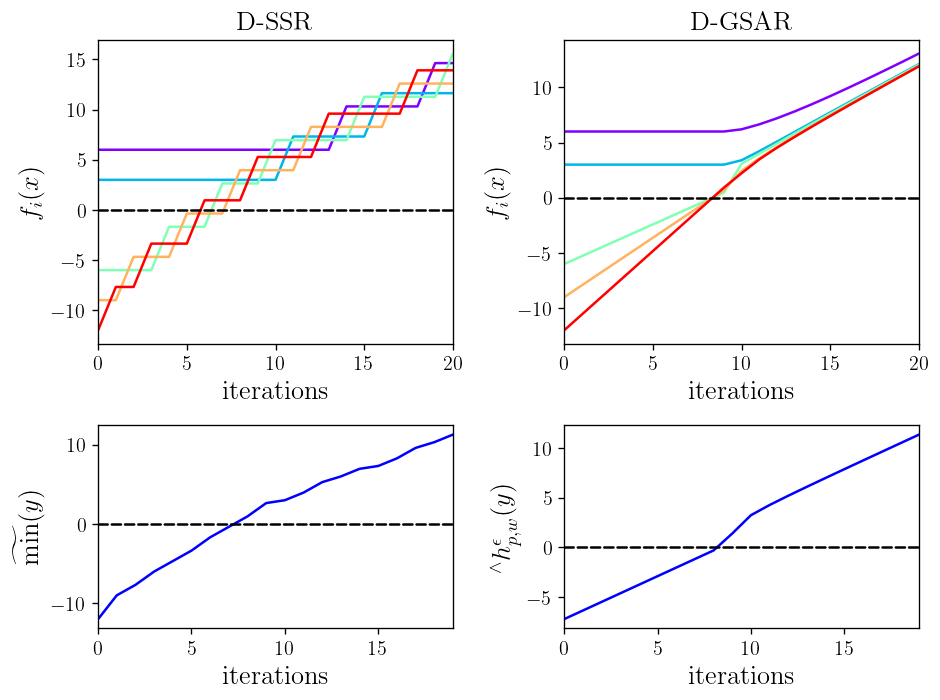

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

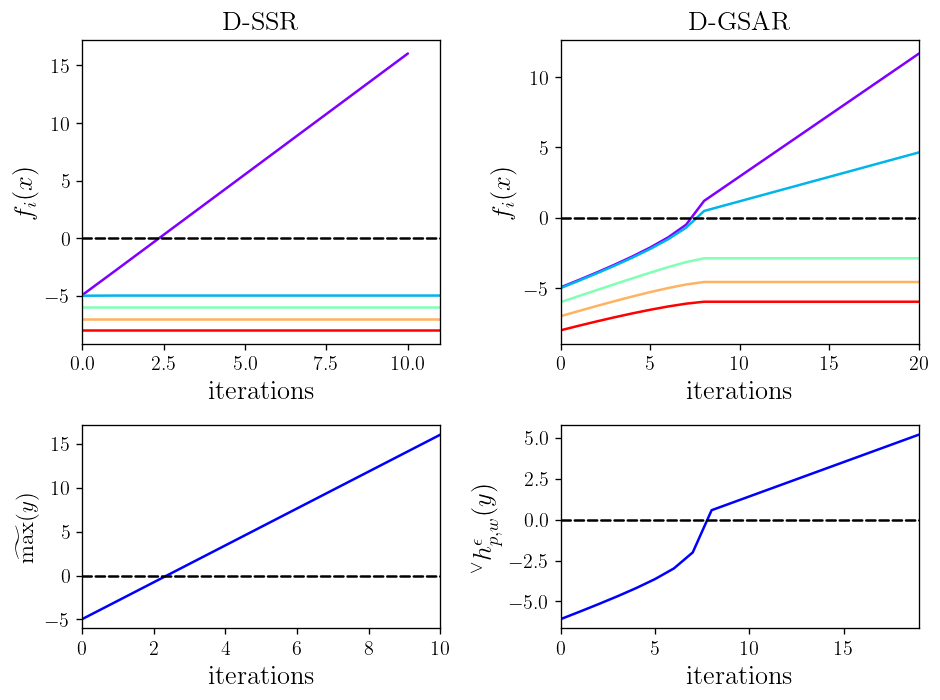

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

In [39]:
grad_des_on_ssr_dgsar()

In [40]:
def grad_des_on_ssr_dgsar():

    # ---------------------------------------------------------------
    # D-SSR D-GSAR Parameters
    
    N = 5
    k = 25
    p = 1
    eps = 1e-8
    weights = np.ones(N)

    f_func_smth, A_func_smth = ssr_sympy(k=k, N=N)

    # ---------------------------------------------------------------
    # Gradient Descent Parameters

    ITE = 20

    x0_and = np.array([-12., -9., -6., 3., 6.])
    alpha_and = 4.32

    x0_or = np.array([-8., -7., -6., -5.0, -4.95])
    alpha_or = 2.1

    # ---------------------------------------------------------------
    # Gradient Descent

    xk_and_1 = x0_and.copy()
    x_list_and_1 = [xk_and_1]
    f_list_and_1 = []

    xk_and_2 = x0_and.copy()
    x_list_and_2 = [xk_and_2]
    f_list_and_2 = []

    xk_or_1 = x0_or.copy()
    x_list_or_1 = [xk_or_1]
    f_list_or_1 = []

    xk_or_2 = x0_or.copy()
    x_list_or_2 = [xk_or_2]
    f_list_or_2 = []

    for i in range(ITE):
        h_and, c_i_w_i = gsar_and(eps, p, weights, xk_and_1)
        xk_and_1 = xk_and_1 + alpha_and * c_i_w_i
        f_list_and_1.append(h_and)
        x_list_and_1.append(xk_and_1)
        
        # h_and, c_i_w_i = gsar_and(eps, 32, weights, xk_and_2)
        h_and, c_i_w_i = f_func_smth(xk_and_2)[0,0], A_func_smth(xk_and_2)[0,:]

        xk_and_2 = xk_and_2 + alpha_and * c_i_w_i
        f_list_and_2.append(h_and)
        x_list_and_2.append(xk_and_2)
        
        h_or, d_i_w_i = gsar_or(eps, p, weights, xk_or_1)
        xk_or_1 = xk_or_1 + alpha_or * d_i_w_i
        f_list_or_1.append(h_or)
        x_list_or_1.append(xk_or_1)
        
        h_or, d_i_w_i = f_func_smth(xk_or_2)[1,0], A_func_smth(xk_or_2)[1,:]
        xk_or_2 = xk_or_2 + alpha_or * d_i_w_i
        f_list_or_2.append(h_or)
        x_list_or_2.append(xk_or_2)
        
    x_list_and_1 = np.vstack(x_list_and_1)
    f_list_and_1 = np.vstack(f_list_and_1)

    x_list_and_2 = np.vstack(x_list_and_2)
    f_list_and_2 = np.vstack(f_list_and_2)

    x_list_or_1 = np.vstack(x_list_or_1)
    f_list_or_1 = np.vstack(f_list_or_1)

    x_list_or_2 = np.vstack(x_list_or_2)
    f_list_or_2 = np.vstack(f_list_or_2)

    # ---------------------------------------------------------------
    # Results - D-SSR

    fig, axs = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3, 2]}, figsize=(8, 6))

    color_1 = iter(cm.rainbow(np.linspace(0, 1, N)))
    plt.figure()
    for i in range(N):
        c = next(color_1)
        axs[0,0].plot(x_list_and_2[:, N-1-i], c=c)
    axs[0,0].axhline(0, c='black', linestyle='dashed')
    axs[0,0].set_xlabel(r'iterations', fontsize=16)
    axs[0,0].set_ylabel('$f_i(x_k)$', fontsize=16)
    axs[0,0].set_title('Conjuction - Always', fontsize=16)

    axs[1,0].plot(f_list_and_2, c='blue')
    axs[1,0].axhline(0, c='black', linestyle='dashed')
    axs[1,0].set_xlabel(r'iterations', fontsize=16)
    axs[1,0].set_ylabel('$\\tilde{\\rho}^{\\varphi_1 \\wedge \\varphi_2 \\wedge \\dots \\wedge \\varphi_5} (x,k)$', fontsize=16)

    color_1 = iter(cm.rainbow(np.linspace(0, 1, N)))
    plt.figure()
    for i in range(N):
        c = next(color_1)
        axs[0,1].plot(x_list_or_2[:, N-1-i], c=c)
    axs[0,1].axhline(0, c='black', linestyle='dashed')
    axs[0,1].set_xlabel(r'iterations', fontsize=16)
    axs[0,1].set_ylabel('$f_i(x_k)$', fontsize=16)
    axs[0,1].set_title('Disjunction - Eventually', fontsize=16)

    axs[1,1].plot(f_list_or_2, c='blue')
    axs[1,1].axhline(0, c='black', linestyle='dashed')
    axs[1,1].set_xlabel(r'iterations', fontsize=16)
    axs[1,1].set_ylabel('$\\tilde{\\rho}^{\\varphi_1 \\vee \\varphi_2 \\vee \\dots \\vee \\varphi_5} (x,k)$', fontsize=16)

    if save_fig: fig.savefig('dssr.' + fig_format, bbox_inches='tight')  

    # ---------------------------------------------------------------
    # Results - D-GSAR

    fig, axs = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3, 2]}, figsize=(8, 6))

    color_1 = iter(cm.rainbow(np.linspace(0, 1, N)))
    plt.figure()
    for i in range(N):
        c = next(color_1)
        axs[0,0].plot(x_list_and_1[:, N-1-i], c=c)
    axs[0,0].axhline(0, c='black', linestyle='dashed')
    axs[0,0].set_xlabel(r'iterations', fontsize=16)
    axs[0,0].set_ylabel('$f_i(x_k)$', fontsize=16)
    axs[0,0].set_title('Conjuction - Always', fontsize=16)

    axs[1,0].plot(f_list_and_1, c='blue')
    axs[1,0].axhline(0, c='black', linestyle='dashed')
    axs[1,0].set_xlabel(r'iterations', fontsize=16)
    axs[1,0].set_ylabel('$\\Gamma^{\\varphi_1 \\wedge \\varphi_2 \\wedge \\dots \\wedge \\varphi_5}_{\\bm{\\epsilon}, \\bm{p}, \\bm{w}} (x,k)$', fontsize=16)

    color_1 = iter(cm.rainbow(np.linspace(0, 1, N)))
    plt.figure()
    for i in range(N):
        c = next(color_1)
        axs[0,1].plot(x_list_or_1[:, N-1-i], c=c)
    axs[0,1].axhline(0, c='black', linestyle='dashed')
    axs[0,1].set_xlabel(r'iterations', fontsize=16)
    axs[0,1].set_ylabel('$f_i(x_k)$', fontsize=16)
    axs[0,1].set_title('Disjunction - Eventually', fontsize=16)
 
    axs[1,1].plot(f_list_or_1, c='blue')
    axs[1,1].axhline(0, c='black', linestyle='dashed')
    axs[1,1].set_xlabel(r'iterations', fontsize=16)
    axs[1,1].set_ylabel('$\\Gamma^{\\varphi_1 \\vee \\varphi_2 \\vee \\dots \\vee \\varphi_5}_{\\bm{\\epsilon}, \\bm{p}, \\bm{w}} (x,k)$', fontsize=16)

    if save_fig: fig.savefig('dgsar.' + fig_format, bbox_inches='tight') 


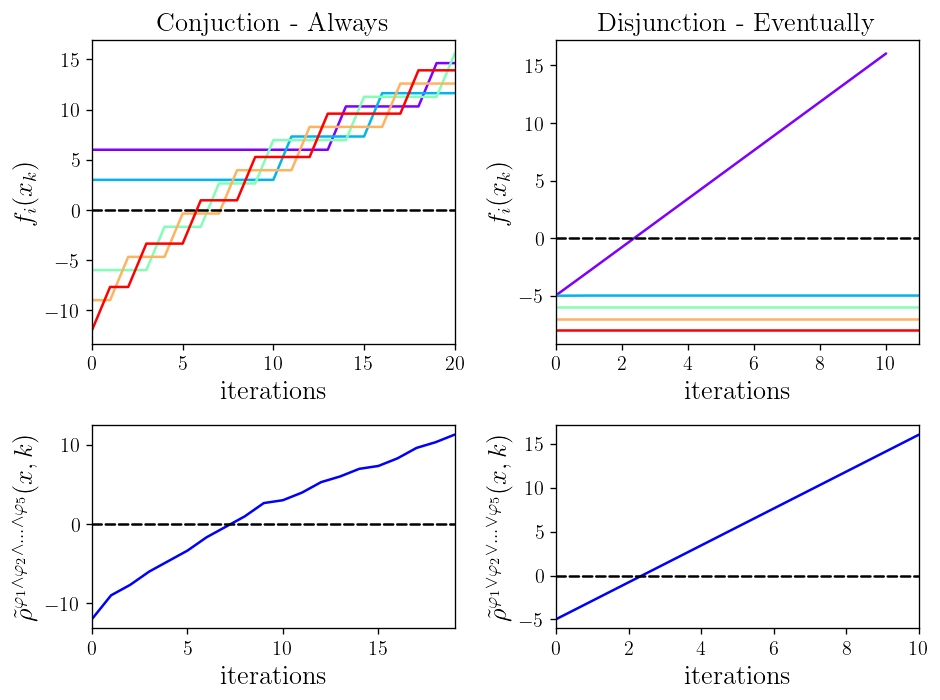

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

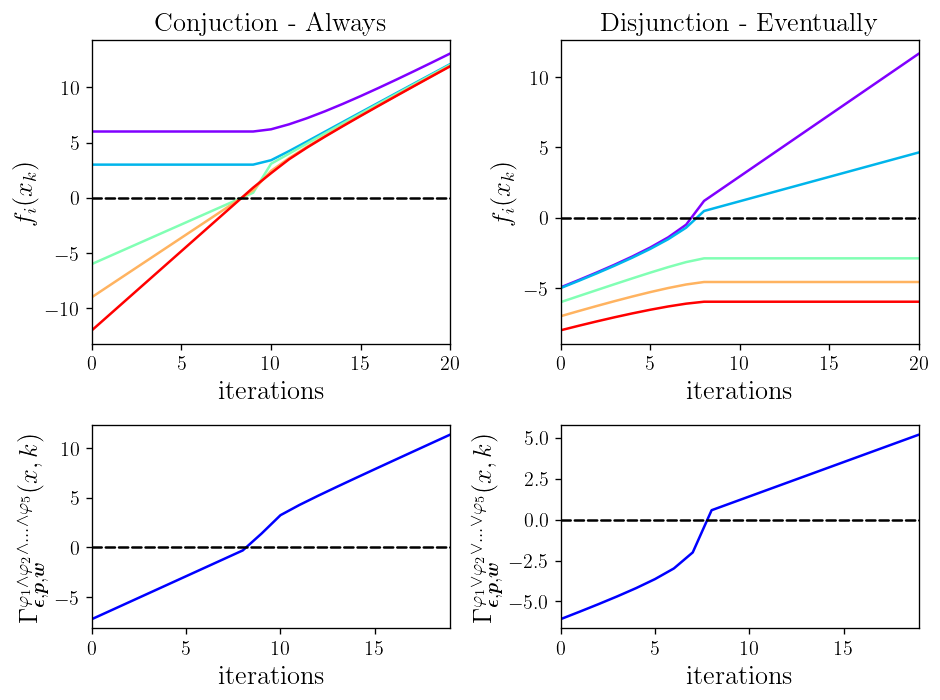

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

In [41]:
grad_des_on_ssr_dgsar()

# Locality & Masking

In [42]:
def RUN_LM(params):

    def f_wp_evnt(xk, uk, dx, du, params, npy=True):

        dist_n = -(-params['wp'][2, 0]+np.linalg.norm(xk - params['wp'][:2, :], axis=0))
        if params['stl_type'] == 'D-SSR':
            f0, g1 = params['f_func_ssr'](dist_n)[1:, :], params['A_func_ssr'](dist_n)[1, :]
        elif params['stl_type'] == 'D-GSAR':
            f0, g1 = gsar_or(params['stl_eps'], params['stl_p'], params['stl_w'], dist_n)
        
        direction = -(xk - params['wp'][:2, :]) / dist_n
        g2 = -(np.diag(g1) @ direction.T).T
        if not(npy):
            lin = ( f0 + cp.sum(cp.multiply(g2, dx)) )
        else:
            lin = ( f0 + (g2 * dx).sum() )
            
        return -f0, -lin

    def f_ptr(dx, du, npy=True):
        if npy:
            return np.sum((np.linalg.norm(dx, axis=0))**2) + np.sum((np.linalg.norm(du, axis=0))**2)
        else:
            return cp.sum((cp.norm(dx, axis=0))**2) + cp.sum((cp.norm(du, axis=0))**2)
        
    def solve_cvx(X, U, w_tr, params):
        
        dX = cp.Variable((2, params['N']))
        dU = cp.Variable((2, params['N'] - 1))
        
        _, lin = f_wp_evnt(X, U, dX, dU, params, npy=False)
        
        mdl_obj = cp.Minimize( lin )
        ptr_obj = cp.Minimize( w_tr * f_ptr(dX, dU, npy=False) )
        
        obj = mdl_obj + ptr_obj
        cons = [ 
                (X + dX)[:, 1:] == (X + dX)[:, 0:-1] + (U + dU),
                (X + dX)[:, 0] == np.array([0., 0.]),
                (X + dX)[:, -1] == np.array([8., 0.]),
                cp.norm(U + dU, axis=0) <= 1.5,
            ]

        problem = cp.Problem(obj, cons)
        
        try:
            # problem.solve(solver='MOSEK')
            problem.solve(solver='ECOS')
        except:
            # problem.solve(solver='ECOS')
            problem.solve(solver='MOSEK')

        return dX.value, dU.value, ptr_obj.value
        
    def prox_linear(params):

        w_tr = params['w_tr0']

        Xk = np.zeros((2, params['N']))
        Uk = np.zeros((2, params['N']-1))

        Xk[0, :] = np.arange(0, params['N'], 1)
        Uk[0, :] = np.ones(params['N']-1)

        nl0, _ = f_wp_evnt(Xk, Uk, Xk-Xk, Uk-Uk, params, npy=True)
        f_list = [nl0]
        x_list = [Xk]

        for i in range(params['N_ite']):
            while True:

                dX, dU, ptr_val = solve_cvx(Xk, Uk, w_tr, params)

                _, lf  = f_wp_evnt(Xk, Uk, dX,  dU,  params, npy=True)
                nl0, _ = f_wp_evnt(Xk, Uk, Xk-Xk, Uk-Uk, params, npy=True)
                nl1, _ = f_wp_evnt(Xk+dX, Uk+dU, Xk-Xk,  Uk-Uk, params, npy=True)

                if params['adaptive_step']:

                    act_chg = nl0 - nl1
                    prd_chg = nl0 - lf

                    rho = act_chg / (prd_chg - ptr_val)

                    if rho < params['r0']:
                        w_tr *= 2.0
                    else:

                        Xk = Xk + dX
                        Uk = Uk + dU

                        f_list.append(nl1)
                        x_list.append(Xk)

                        if params['r2'] <= rho:
                            w_tr /= 2.0
                            w_tr = np.maximum(w_tr, 0.1)

                        break
                else:
                    Xk = Xk + dX
                    Uk = Uk + dU

                    f_list.append(nl1)
                    x_list.append(Xk)
                    break

        f_list = -np.vstack(f_list)
        x_list = (np.vstack(x_list)).reshape(-1, 2, params['N'])
        
        return f_list, x_list

    def plot(params, results):
        fig, axs = plt.subplots(nrows=3, ncols=2, gridspec_kw={'height_ratios': [5, 3, 2]}, figsize=(8, 8))

        gs = axs[0, 0].get_gridspec()
        for ax in axs[0, :]:
            ax.remove()
        axa = fig.add_subplot(gs[0, :])
            
        circle = plt.Circle((params['wp'][0,0], params['wp'][1,0]), params['wp'][2,0], color='blue', clip_on=False, fill=False)
        axa.add_patch(circle)

        cc = plt.cm.rainbow(np.linspace(0, 1, params['N']))

        axa.plot(results['x_dgsar'][0,0,:], results['x_dgsar'][0,1,:], c='black', label='Initial Trajectory', linestyle='dotted')
        # axa.scatter(results['x_dgsar'][0,0,:], results['x_dgsar'][0,1,:], c='black')
        axa.scatter(results['x_dgsar'][0,0,:], results['x_dgsar'][0,1,:], c = cc, alpha = 1, s=50, zorder=10)

        axa.plot(results['x_ssr'][-1,0,:], results['x_ssr'][-1,1,:], c='red', label='D-SSR', linestyle='dotted')
        # axa.scatter(results['x_ssr'][-1,0,:], results['x_ssr'][-1,1,:], c='red')
        axa.scatter(results['x_ssr'][-1,0,:], results['x_ssr'][-1,1,:], c = cc, alpha = 1, s=50, zorder=10)
        
        axa.plot(results['x_dgsar'][-1,0,:], results['x_dgsar'][-1,1,:], c='blue', label='D-GSAR', linestyle='dotted')
        # axa.scatter(results['x_dgsar'][-1,0,:], results['x_dgsar'][-1,1,:], c='blue')
        axa.scatter(results['x_dgsar'][-1,0,:], results['x_dgsar'][-1,1,:], c = cc, alpha = 1, s=50, zorder=10)
            
        axa.set_aspect('equal')
        axa.set_title('Position [m]', fontsize=16)   
        axa.legend(prop={'size': 14})

        color_1 = iter(cm.rainbow(np.linspace(0, 1, params['N'])))
        plt.figure()
        for i in range(params['N']):
            c = next(color_1)
            all_dist = -(-params['wp'][2, 0]+np.linalg.norm(results['x_ssr'][:,:,i].T - params['wp'][:2, :], axis=0))
            axs[1,0].plot(all_dist, c=c)
        axs[1,0].axhline(0, c='black', linestyle='dashed')
        axs[1,0].set_xlabel(r'iterations', fontsize=16)
        axs[1,0].set_ylabel('$f(x_k)$', fontsize=16)
        axs[1,0].set_title('D-SSR', fontsize=16)

        axs[2,0].plot(results['f_ssr'], c='blue')
        axs[2,0].axhline(0, c='black', linestyle='dashed')
        axs[2,0].set_xlabel(r'iterations', fontsize=16)
        axs[2,0].set_ylabel('$$\\tilde{\\rho}^{ \\bm{F}_{[1:K]} \\varphi} (x,0)$$', fontsize=16)

        color_1 = iter(cm.rainbow(np.linspace(0, 1, params['N'])))
        for i in range(params['N']):
            c = next(color_1)
            all_dist = -(-params['wp'][2, 0]+np.linalg.norm(results['x_dgsar'][:,:,i].T - params['wp'][:2, :], axis=0))
            axs[1,1].plot(all_dist, c=c)
        axs[1,1].axhline(0, c='black', linestyle='dashed')
        axs[1,1].set_xlabel(r'iterations', fontsize=16)
        axs[1,1].set_ylabel('$f(x_k)$', fontsize=16)
        axs[1,1].set_title('D-GSAR', fontsize=16)

        axs[2,1].plot(results['f_dgsar'], c='blue')
        axs[2,1].axhline(0, c='black', linestyle='dashed')
        axs[2,1].set_xlabel(r'iterations', fontsize=16)
        axs[2,1].set_ylabel('$\\Gamma^{ \\bm{F}_{[1:K]} \\varphi}_{\\bm{\\epsilon}, \\bm{p}, \\bm{w}} (x,0)$', fontsize=16)

        if save_fig: fig.savefig('locality_masking.' + fig_format, bbox_inches='tight') 

    results = dict()

    params['stl_type'] = 'D-SSR'
    results['f_ssr'], results['x_ssr'] = prox_linear(params)

    params['stl_type'] = 'D-GSAR'
    results['f_dgsar'], results['x_dgsar'] = prox_linear(params)

    plot(params, results)

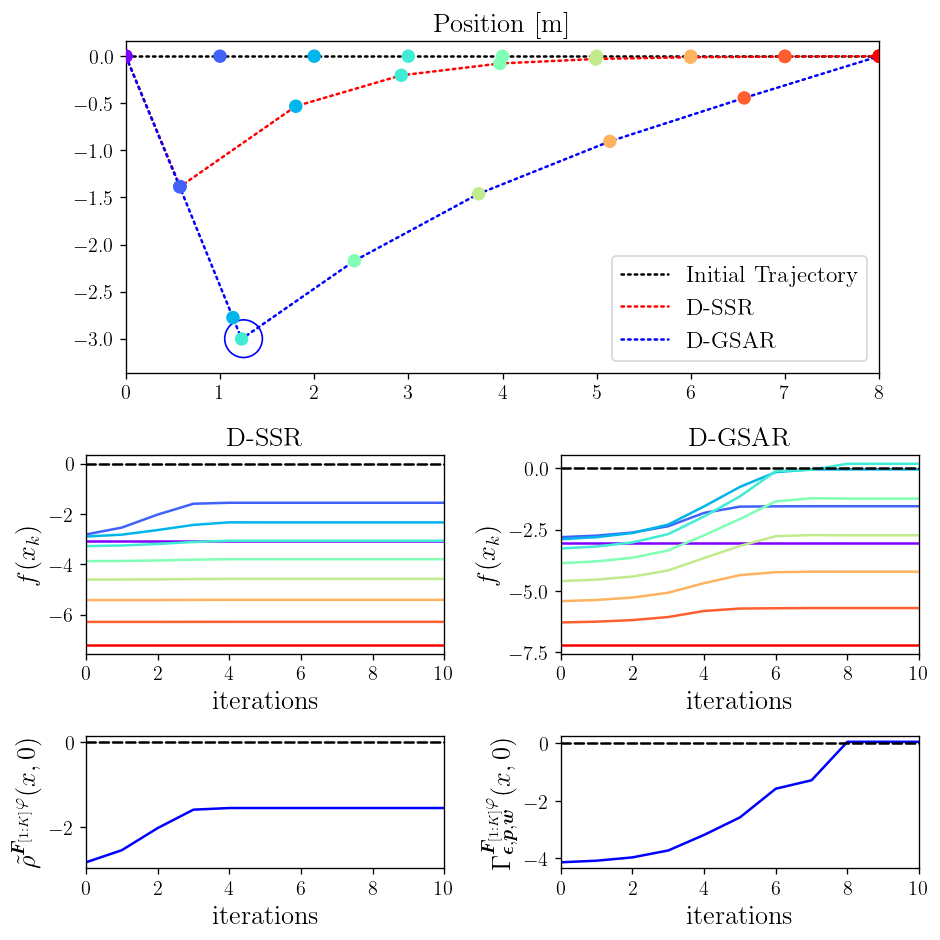

<Figure size 768x576 with 0 Axes>

In [43]:
params = dict()

# Problem
params['N'] = 9
params['wp'] = np.array([[1.25], [-3], [0.2]])

# STL
params['stl_eps'] = 1e-8
params['stl_p'] = 1
params['stl_w'] = np.ones(params['N'])
params['f_func_ssr'], params['A_func_ssr'] = ssr_sympy(k=25, N=params['N'])

# Prox-linear
params['N_ite'] = 10
params['w_tr0'] = 0.8
params['r0'] = 0.01
params['r1'] = 0.1
params['r2'] = 0.9
params['adaptive_step'] = True

RUN_LM(params)


# Successive Convexification for Trajectory Optimization with Signal Temporal Logic Specifications

## Parameters

In [44]:
def params_fcn() -> T.Dict[str, T.Any]:

    """
    Static parameters for the scenario
    """

    total_time = 8.0  # Total simulation time [s]
    N = 17 # Total number of nodes
    t_scp = total_time / (N-1)

    n_states = 4 # p_x, p_y, v_x, v_y
    n_controls = 2 # a_x, a_y

    x_init  = np.array([0., 0., 0., 0.])  # [x, y, x_dot, y_dot]
    x_final = np.array([8., 0., 0., 0.])  # [x, y, x_dot, y_dot]

    X_last = np.zeros((n_states, N))
    U_last = np.zeros((n_controls, N))
    X_last[0, :] = np.linspace(x_init[0], x_final[0], N)

    return dict(
        # ---------------------------------------------------------------------------------------------------

        # General Parameters
        total_time = total_time,
        N = N,
        t_scp = t_scp,
        dt = t_scp,

        n_states = n_states,
        n_controls = n_controls,
        inp_param = 'FOH',

        x_init  = x_init,
        x_final = x_final,

        X_last = X_last,
        U_last = U_last,
                
        vehicle_v_max = 2.0, # [m/s]
        vehicle_v_max_evnt = 1.0, # [m/s]
        vehicle_a_max = 1.5, # [m/s^2]
        cd = 0.01,

        # ---------------------------------------------------------------------------------------------------

        # Prox-linear Parameters
        ite = 20, # Total number of iterations for the prox-linear algorithm
        w_obj = 1., # Penalization weight for the actual cost
        w_con = 1e3, # Penalization weight for the constraints
        
        # Prox-linear via adaptive step-size
        adaptive_step = True, # Updates the penalization cost of prox-linear
        w_ptr = 1e-2, # Initial penaliztion weight for the trust-regrion
        w_ptr_min = 0.001, # Minimum penaliztion weight for the trust-regrion
        r0 = 0.01, # Minimum linearization accuracy to accept the SCP iteration and increase w_ptr
        r1 = 0.1, # Minimum linearization accuracy to use the same w_ptr
        r2 = 0.9, # Minimum linearization accuracy to decrease the w_ptr

        # ---------------------------------------------------------------------------------------------------

        # STL
        stl_eps = 1e-8,
        stl_p = 1,
        stl_w_phi_1 = np.ones(N),
        stl_w_phi_2 = np.ones(N),
        stl_w_phi_12 = np.ones(2),
        p_w = np.array([[1.25], [-2.], [0.2]]), # Way-point
        
        # ---------------------------------------------------------------------------------------------------

        # Integration
        rk4_steps_dyn = 5,
        rk4_steps_J = 5,
    )

## Objective and Constraint Functions

In [45]:
def f_wp(xk : np.ndarray, 
         dx : np.ndarray,
         p_w : np.ndarray,
         npy : bool) -> T.Tuple[T.Any]:
    
    dist_c = np.linalg.norm(xk[:2, :] - p_w[:2, :], axis=0)
    dist = (p_w[2, 0]-dist_c)
    direction = -(xk[:2, :] - p_w[:2, :]) / (dist_c + 1e-8)
    
    f_0 = dist
    if not(npy):
        l_k = ( f_0 + cp.sum(cp.multiply(direction, dx[:2, :]), axis=0) )
    else:
        l_k = ( f_0 + (direction * dx[:2, :]).sum(axis=0) )
        
    return f_0, l_k

def f_spd(xk : np.ndarray,
          dx : np.ndarray,
          spd_lim : np.ndarray,
          npy : bool) -> T.Tuple[T.Any]:
    
    speed = np.linalg.norm(xk[2:4, :], axis=0)
    dist = (spd_lim-speed)
    direction = -(xk[2:4, :]) / (speed + 1e-8)
    
    f_0 = dist
    if not(npy):
        l_k = ( f_0 + cp.sum(cp.multiply(direction, dx[2:4, :]), axis=0) )
    else:
        l_k = ( f_0 + (direction * dx[2:4, :]).sum(axis=0) )
        
    return f_0, l_k

def f_until(xk : np.ndarray,
            dxk : np.ndarray,
            params : T.Dict,
            npy : bool=True) -> T.Tuple[T.Any]:
    
    # ---------------------------------------------------
    f_0_wp, l_k_wp = f_wp(xk=xk, 
                              dx=dxk,
                              p_w=params['p_w'],
                              npy=npy)
    # ---------------------------------------------------
    f_0_spd, l_k_spd = f_spd(xk=xk,
                                 dx=dxk,
                                 spd_lim=params['vehicle_v_max_evnt'], 
                                 npy=npy)
    # ---------------------------------------------------
    f_0_until, phi_1_grad, phi_2_grad = UNTIL(params['stl_eps'], 
                                              params['stl_p'],
                                              params['stl_w_phi_1'], 
                                              params['stl_w_phi_2'], 
                                              params['stl_w_phi_12'], 
                                              f_0_spd, 
                                              f_0_wp)
    # ---------------------------------------------------

    if npy:
        l_k_until = f_0_until + np.sum(phi_2_grad*(l_k_wp-f_0_wp) + phi_1_grad*(l_k_spd-f_0_spd))
    else:
        l_k_until = f_0_until + cp.sum(phi_2_grad*(l_k_wp-f_0_wp) + phi_1_grad*(l_k_spd-f_0_spd))

    return -f_0_until, -l_k_until

## Vehcile Dynamics

In [46]:
def vehicle_dynamics(params: T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    def f(x,u,p):
        norm_ = (x[2]**2+x[3]**2)**(0.5)
        return np.array([x[2], 
                         x[3], 
                         u[0] - params['cd'] * x[2] * norm_, 
                         u[1] - params['cd'] * x[3] * norm_, 
                        ])

    def A(x,u,p):
        norm_ = (x[2]**2+x[3]**2 + 1e-6)**(0.5)
        return np.array([[0, 0, 1, 0],
                         [0, 0, 0, 1],
                         [0, 0, -params['cd'] * (norm_ + x[2]**2 / norm_), -params['cd'] * (      x[2]*x[3] / norm_)],
                         [0, 0, -params['cd'] * (      x[2]*x[3] / norm_), -params['cd'] * (norm_ + x[3]**2 / norm_)],
                        ])
        
    def B(x,u,p):
        return np.array([[0, 0], 
                         [0, 0],
                         [1, 0], 
                         [0, 1]])

    params['f_func'] = f
    params['A_func'] = A
    params['B_func'] = B

    return params

## Integration

In [47]:
def rk4(func : T.Any,
        y0 : np.ndarray, 
        tf : float, 
        steps : int, 
        *args : T.Tuple[T.Any]) -> np.ndarray:
    """
    Implementation of the fourth-order Runge-Kutta (RK4) method for numerical integration.

    Parameters:
    - f: Function representing the system of ordinary differential equations (ODEs).
    - y0: Initial conditions (numpy array, n-dimensional column vector).
    - t: Time points for which the solution is calculated.

    Returns:
    - y: Solution of the ODEs at each time point.
    """

    t = np.linspace(0, tf, int(steps))  # Time points

    # Ensure y0 is a NumPy array (n-dimensional column vector)
    # y0 = np.array(y0).reshape(-1, 1)
    y0 = y0.reshape(-1, 1)

    # Initialize solution array
    y = np.zeros((len(t), len(y0)))
    y[0, :] = y0.flatten()

    # Perform RK4 integration
    for i in range(len(t) - 1):

        h = t[i + 1] - t[i]
        k1 = h * func(y[i], t[i], args)
        k2 = h * func(y[i] + 0.5 * k1, t[i] + 0.5 * h, args)
        k3 = h * func(y[i] + 0.5 * k2, t[i] + 0.5 * h, args)
        k4 = h * func(y[i] + k3, t[i] + h, args)

        y[i + 1, :] = y[i, :] + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return y

In [48]:
def dxdt(x : np.ndarray,
         t : float, 
         *args : T.Tuple[T.Any],
        ) -> np.ndarray:

    """
    return: x_dot(t)
    """

    tt, tf, u_0 , u_1, params = args[0]
    
    p = np.zeros(1)
    
    if params['inp_param'] == 'FOH':
        u = u_0 + (t / tf) * (u_1 - u_0)
    elif params['inp_param'] == 'ZOH':
        u = u_0.copy()
        
    return params['f_func'](x, u, p)

def integrate_dynamics(x : np.ndarray,
                       u_0 : np.ndarray,
                       u_1 : np.ndarray,
                       params : T.Dict[str, T.Any],
                       tf : float,
                       tt : float,
                      ) -> T.Tuple[np.ndarray]:
    """
    Integration of the vehicle dynamics [0, tf]
    return: x[t+dt] and u
    """
    x_next = rk4(dxdt, x, tf, params['rk4_steps_dyn'], tt, tf, u_0, u_1, params)[-1,:]
    return x_next

def integrate_multiple(X, U, params):
    
    x_k1_list = []
    for k in range(X.shape[1] - 1):
        tt = k * params['t_scp']
        x_k1 = integrate_dynamics(X[:, k], U[:, k], U[:, k+1], params, params['t_scp'], tt)
        x_k1_list.append(x_k1)
        
    return (np.vstack(x_k1_list)).T

## Discretization

In [49]:
def dVdt(V : np.ndarray, 
         t : float, 
         *args : T.Tuple[T.Any],
        ) -> np.ndarray:
    """
    ODE function to compute dVdt.
    V: Evaluation state V = [x, Phi_A, B_bar, C_bar, z_bar]
    t: Evaluation time
    u: Input at start of interval
    return: Derivative at current time and state dVdt
    """

    args = args[0]
    u_0, u_1, tt, params = args

    n_x = params['n_states']
    n_u = params['n_controls']
    
    i0 = 0
    i1 = n_x
    i2 = i1 + n_x*n_x
    i3 = i2 + n_x*n_u
    i4 = i3 + n_x*n_u
    i5 = i4 + n_x
    
    x = V[i0:i1]
    p = np.zeros(1)

    if params['inp_param'] == 'ZOH':
        beta = 0.
    elif params['inp_param'] == 'FOH':
        beta = t / params['t_scp']
    alpha = 1 - beta
    
    u = u_0 + beta * (u_1 - u_0)

    A_subs = params['A_func'](x, u, p)
    B_subs = params['B_func'](x, u, p)
    f_subs = params['f_func'](x, u, p)
    
    z_t = np.squeeze(f_subs) - np.matmul(A_subs, x) - np.matmul(B_subs, u)
    
    dVdt = np.zeros_like(V)
    dVdt[i0:i1] = f_subs.T
    dVdt[i1:i2] = np.matmul(A_subs, V[i1:i2].reshape((n_x, n_x))).reshape(-1)
    dVdt[i2:i3] = (np.matmul(A_subs, V[i2:i3].reshape((n_x, n_u))) + B_subs * alpha).reshape(-1)
    dVdt[i3:i4] = (np.matmul(A_subs, V[i3:i4].reshape((n_x, n_u))) + B_subs * beta).reshape(-1)
    dVdt[i4:i5] = (np.matmul(A_subs, V[i4:i5]).reshape(-1) + z_t)

    return dVdt

def calculate_discretization(X : np.ndarray, 
                             U : np.ndarray, 
                             params : T.Dict[str, T.Any],
                            ) -> T.Dict[str, T.Any]:
    """
    Calculate discretization for given states, inputs and total time.
    X: Matrix of states for all time points
    U: Matrix of inputs for all time points
    return: The discretization matrices
    """
    
    n_x = params['n_states']
    n_u = params['n_controls']
    
    i0 = 0
    i1 = n_x
    i2 = i1 + n_x*n_x
    i3 = i2 + n_x*n_u
    i4 = i3 + n_x*n_u
    i5 = i4 + n_x
    
    V0 = np.zeros(i5)
    V0[i1:i2] = np.eye(n_x).reshape(-1)

    f_bar = np.zeros((n_x, params['N']-1))
    A_bar = np.zeros((n_x * n_x, params['N']-1))
    B_bar = np.zeros((n_x * n_u, params['N']-1))
    C_bar = np.zeros((n_x * n_u, params['N']-1))
    z_bar = np.zeros((n_x, params['N']-1))

    for k in range(params['N'] - 1):
        V0[i0:i1] = X[:, k]

        tt = k*params['t_scp']
        V = rk4(dVdt, V0, params['t_scp'], params['rk4_steps_J'], U[:, k], U[:, k+1], tt, params)[-1,:]

        # flatten matrices in column-major (Fortran) order for cvxpy
        f_bar[:, k] = V[i0:i1]
        Phi = V[i1:i2].reshape((n_x, n_x))
        A_bar[:, k] = Phi.flatten(order='F')
        B_bar[:, k] = (V[i2:i3].reshape((n_x, n_u))).flatten(order='F')
        C_bar[:, k] = (V[i3:i4].reshape((n_x, n_u))).flatten(order='F')
        z_bar[:, k] = (V[i4:i5])
    


    params['f_bar'] = f_bar
    params['A_bar'] = A_bar
    params['B_bar'] = B_bar
    params['C_bar'] = C_bar
    params['z_bar'] = z_bar
    
    return params

## Linear / Nonlinear Cost

In [50]:
def scp_non_linear_cost(X_new : np.ndarray,
                        U_new : np.ndarray,
                        X_last : np.ndarray,
                        U_last : np.ndarray,
                        nu_new : np.ndarray,
                        nl_nu_new : np.ndarray,
                        w_tr : float,
                        params : T.Dict[str, T.Any],
                       ) -> T.Tuple[np.ndarray]:
    """
    Returns the nonlinear or linearized cost value of the SCP problem
    Required for prox-linear with adaptive step-size
    """

    cost_dict = dict()

    cost_dict['ptr_cost'] = w_tr * (np.linalg.norm(X_new -  X_last, axis=0)**2 + np.linalg.norm(U_new -  U_last, axis=0)**2).sum()

    cost_dict['lin_cost'] = cost_dict['ptr_cost']
    cost_dict['n_lin_cost'] = cost_dict['ptr_cost']

    _, lin_until_cost = f_until(X_last, X_new-X_last,  params, npy=True)
    n_lin_until_cost, _ = f_until(X_new, X_new-X_new,  params, npy=True)

    cost_dict['lin_until_cost'] = params['w_obj'] * lin_until_cost
    cost_dict['n_lin_until_cost'] = params['w_obj'] * n_lin_until_cost

    cost_dict['lin_cost'] += cost_dict['lin_until_cost']
    cost_dict['n_lin_cost'] += cost_dict['n_lin_until_cost']

    cost_dict['lin_dyn_cost'] = params['w_con'] * np.linalg.norm(nu_new.reshape(-1), 1)
    cost_dict['n_lin_dyn_cost'] = params['w_con'] * np.linalg.norm(nl_nu_new.reshape(-1), 1)

    cost_dict['lin_cost'] += cost_dict['lin_dyn_cost']
    cost_dict['n_lin_cost'] += cost_dict['n_lin_dyn_cost']
        
    return cost_dict

## Convex Problem (sub-problem)

In [51]:
def solve_convex_problem(X_last : np.ndarray,
                         U_last : np.ndarray,
                         w_tr : float,
                         params : T.Dict[str, T.Any],
                        ) -> T.Tuple[np.ndarray]:
       
    """
    Solves the convex sub-problem using ECOS or MOSEK and retruns the optimal values of X and U
    """
    
    X  = cp.Variable((params['n_states'],   params['N']))
    U  = cp.Variable((params['n_controls'], params['N']))
    nu = cp.Variable((params['n_states'],   params['N']-1))

    cost = 0
    constraints = []

    cost += params['w_con'] * cp.sum(cp.abs(nu))

    _, lin_until_cost = f_until(X_last, X - X_last, params, npy=False)
    cost += params['w_obj'] * lin_until_cost

    cost += w_tr * (cp.sum(cp.norm(X - X_last, axis=0)**2) + cp.sum(cp.norm(U - U_last, axis=0)**2)) # Trust region

    constraints += [X[0:4, -1] == params['x_final'][0:4]] # Final position and velocity of the vehicle
    constraints += [cp.norm(X[2:4, 1:-1], axis=0) <= params['vehicle_v_max']]
    constraints += [X[:, 0] == params['x_init']]
    constraints += [cp.norm(U[:, :], axis=0) <= params['vehicle_a_max']]
    
    constraints += [
        X[:, k + 1] ==
        cp.reshape(params['A_bar'][:, k], (params['n_states'], params['n_states'])) @ X[:, k]
        + cp.reshape(params['B_bar'][:, k], (params['n_states'], params['n_controls'])) @ U[:, k]
        + cp.reshape(params['C_bar'][:, k], (params['n_states'], params['n_controls'])) @ U[:, k+1]
        + params['z_bar'][:, k]
        + nu[:, k]
        for k in range(params['N'] - 1)
    ]

    # Create the optimization problem
    problem = cp.Problem(cp.Minimize(cost), constraints)

    # Solve the optimization problem
    try:
        problem.solve(solver='ECOS')
    except:
        problem.solve(solver='MOSEK')
    
    return X.value, U.value, nu.value

## Prox-linear

In [52]:
def prox_linear(params : T.Dict[str, T.Any],
               ) -> T.Dict[str, T.Any]:

    """
    Solves the non-convex trajectory optimization problem using Penalized Trust Region method (PTR)
    """
        
    X_last = params['X_last']
    U_last = params['U_last']
    w_tr = params['w_ptr']
    last_cost = None
    
    prox_results = dict()
    prox_results['ptr_cost_list'] = []
    prox_results['non_lin_cost_list'] = []
    prox_results['dynamical_cost_list'] = []
    prox_results['stl_cost_list'] = []
    prox_results['w_tr_list'] = []

    for i in range(params['ite']):
        params = calculate_discretization(X_last, U_last, params)
        while True:
            if w_tr > 1e8: break
            
            X_new, U_new, nu_new = solve_convex_problem(X_last, U_last, w_tr, params)

            X_nl = X_new.copy()
            X_nl[:, 1:] = integrate_multiple(X_new, U_new, params)

            cost_dict = scp_non_linear_cost(X_new, U_new,  X_last, U_last, nu_new, (X_new - X_nl),  w_tr, params)
                
            if not(last_cost) or not(params['adaptive_step']):
                X_last = X_new.copy()
                U_last = U_new.copy()
                last_cost = cost_dict['n_lin_cost']
                
                prox_results['ptr_cost_list'].append(cost_dict['ptr_cost'])
                prox_results['non_lin_cost_list'].append(cost_dict['n_lin_cost'])
                prox_results['dynamical_cost_list'].append(np.sum(np.linalg.norm((X_new - X_nl)[:, :], axis=1, ord=1)))
                prox_results['stl_cost_list'].append(cost_dict['n_lin_until_cost'])
                prox_results['w_tr_list'].append(w_tr)
                break

            else:
                delta_J = last_cost - cost_dict['n_lin_cost']
                delta_L = last_cost - cost_dict['lin_cost']

                rho = delta_J / delta_L
                if rho <= params['r0']:
                    w_tr = w_tr * 2

                else:
                    X_last = X_new.copy()
                    U_last = U_new.copy()
                    last_cost = cost_dict['n_lin_cost']
                    
                    prox_results['ptr_cost_list'].append(cost_dict['ptr_cost'])
                    prox_results['non_lin_cost_list'].append(cost_dict['n_lin_cost'])
                    prox_results['dynamical_cost_list'].append(np.sum(np.linalg.norm((X_new - X_nl)[:, :], axis=1, ord=1)))
                    prox_results['stl_cost_list'].append(cost_dict['n_lin_until_cost'])
                    prox_results['w_tr_list'].append(w_tr)

                    if params['r2'] <= rho:
                        w_tr = np.maximum(w_tr / 2, params['w_ptr_min'])
                    break
    
    prox_results['X_new'] = X_last
    prox_results['U_new'] = U_last

    return prox_results

## RUN

In [53]:
def RUN(params : T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    x_all = [params['x_init'][0:4]]
    u_all = []

    prox_results = prox_linear(params)
    
    x_next = params['x_init'].copy()
    times = np.arange(0, params['total_time']+params['dt'], params['dt'])
    for i_int in tqdm(range(len(times)-1)):
        params['t_curr'] = times[i_int]
        idx = int(params['t_curr'] / params['t_scp'])

        if params['inp_param'] == 'ZOH':
            u_0 = prox_results['U_new'][:, idx]
            u_1 = prox_results['U_new'][:, idx]
            
        elif params['inp_param'] == 'FOH':
            t0_scp = params['t_curr'] % (params['t_scp'])

            beta = t0_scp/params['t_scp']
            u_0 = prox_results['U_new'][:, idx] + beta * (prox_results['U_new'][:, idx+1] - prox_results['U_new'][:, idx])
            
            beta = (t0_scp+params['dt'])/params['t_scp']
            u_1 = prox_results['U_new'][:, idx] + beta * (prox_results['U_new'][:, idx+1] - prox_results['U_new'][:, idx])
            
        x_next = integrate_dynamics(x_next, u_0, u_1, params, params['dt'], tt=0)
        x_all.append(x_next[0:4])
        u_all.append(np.vstack((u_0, u_1)))

    scp_results = dict()
    scp_results['times'] = times

    scp_results['x_all'] = np.vstack(x_all)
    scp_results['u_all'] = np.dstack(u_all)
    scp_results['x_nmpc_all'] = np.dstack(prox_results['X_new'])
    scp_results['u_nmpc_all'] = np.dstack(prox_results['U_new'])

    scp_results['ptr_cost_list_all'] = np.array([prox_results['ptr_cost_list']])
    scp_results['non_lin_cost_list_all'] = np.array([prox_results['non_lin_cost_list']])
    scp_results['dynamical_cost_list_all'] = np.array([prox_results['dynamical_cost_list']])
    scp_results['stl_cost_list_all'] = np.array([prox_results['stl_cost_list']])
    scp_results['w_tr_list_all'] = np.array([prox_results['w_tr_list']])

    return scp_results

In [54]:
params0 = params_fcn()
params = vehicle_dynamics(params0)
results = RUN(params)

100%|██████████| 16/16 [00:00<00:00, 4927.59it/s]


Dynamical Cost 1.2545430644546904e-08
STL Cost -0.053301970002761725
TR Weight 10.24


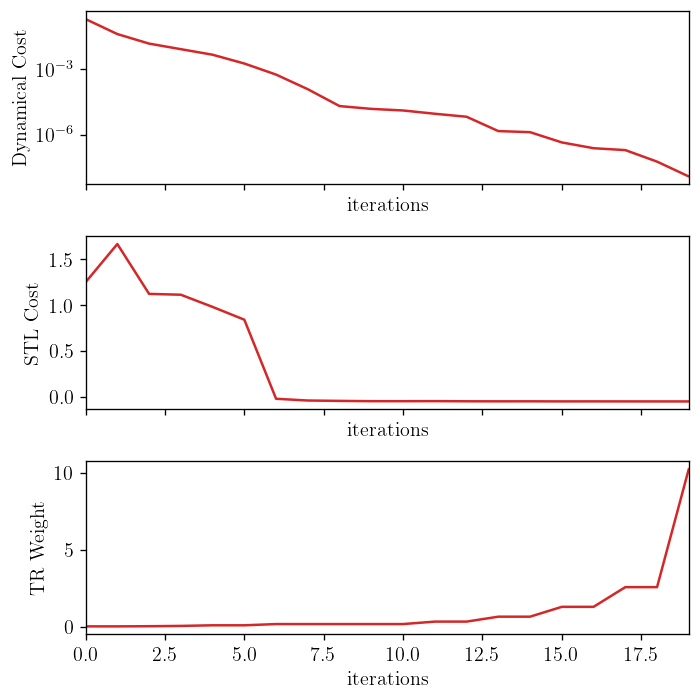

In [55]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(6, 6), nrows=3, sharex=True)

ax0.plot(results['dynamical_cost_list_all'][0,:])
ax0.set_xlabel(r'iterations', fontsize=12)
ax0.set_ylabel('Dynamical Cost', fontsize=12)
ax0.set_yscale('log')

ax1.plot( results['stl_cost_list_all'][0, :] )
ax1.set_xlabel(r'iterations', fontsize=12)
ax1.set_ylabel(r'STL Cost', fontsize=12)

ax2.plot(results['w_tr_list_all'][0,:])
ax2.set_xlabel(r'iterations', fontsize=12)
ax2.set_ylabel(r'TR Weight', fontsize=12)


print('Dynamical Cost', results['dynamical_cost_list_all'][0,-1])
print('STL Cost', results['stl_cost_list_all'][0,-1])
print('TR Weight', results['w_tr_list_all'][0,-1])

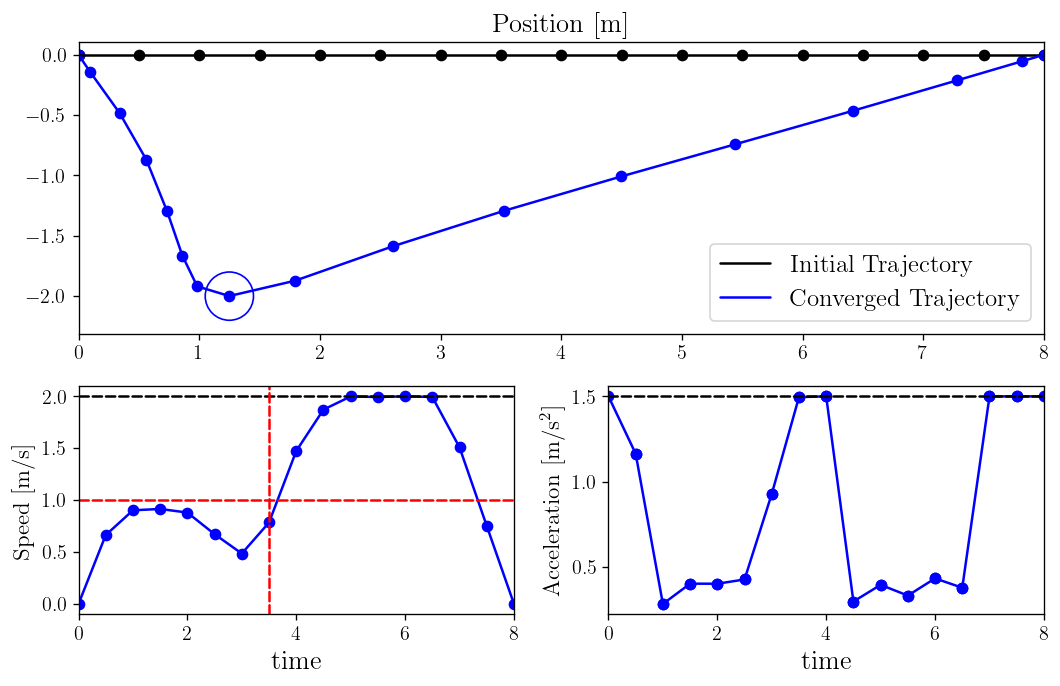

In [56]:
fig, axs = plt.subplots(2, 2, gridspec_kw={'height_ratios': [5, 3]}, figsize=(9, 6))

gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:
    ax.remove()
axa = fig.add_subplot(gs[0, :])

circle = plt.Circle(params['p_w'][:2], params['p_w'][2], color='blue', clip_on=False, fill=False)
axa.add_patch(circle)

axa.plot(params['X_last'][0,:], params['X_last'][1,:], c='black', label='Initial Trajectory')
axa.scatter(params['X_last'][0,:], params['X_last'][1,:], c='black')

axa.plot(results['x_all'][:,0], results['x_all'][:,1], c='blue', label='Converged Trajectory')
axa.scatter(results['x_all'][:,0], results['x_all'][:,1], c='blue')

axa.set_aspect('equal')
axa.set_title(r'Position [m]', fontsize=16)
axa.legend(prop={'size': 15})

axs[1,0].plot(results['times'], np.linalg.norm(results['x_all'][:,2:4], axis=1), c='blue')
axs[1,0].scatter(results['times'], np.linalg.norm(results['x_all'][:,2:4], axis=1), c='blue')
axs[1,0].axhline(y=params['vehicle_v_max'], c='black', linestyle='dashed')
axs[1,0].axhline(y=params['vehicle_v_max_evnt'], c='red', linestyle='dashed')
fsbl_idx = np.argwhere((np.linalg.norm(results['x_all'][:,0:2].T - params['p_w'][0:2,:], axis=0) - params['p_w'][2,0])<= 0)
axs[1,0].axvline(x=results['times'][fsbl_idx[0,0]], c='red', linestyle='dashed')
axs[1,0].set_xlabel(r'time', fontsize=16)
axs[1,0].set_ylabel('Speed [m/s]', fontsize=14)

x_time = np.dstack((results['times'][:-1], results['times'][1:])).reshape(-1)
axs[1,1].plot(x_time, np.linalg.norm(results['u_all'][:,0:2,:], axis=1).reshape(-1, order='F'), c='blue')
axs[1,1].scatter(x_time, np.linalg.norm(results['u_all'][:,0:2,:], axis=1).reshape(-1, order='F'), c='blue')
axs[1,1].axhline(y=params['vehicle_a_max'], c='black', linestyle='dashed')
axs[1,1].set_xlabel(r'time', fontsize=16)
axs[1,1].set_ylabel('Acceleration [m/s$^2$]', fontsize=14)

if save_fig: fig.savefig('Num_sim.' + fig_format, bbox_inches='tight') 